# Run script

> Stage 2 run script. Functions and classes are imports from `s2_stroke_rehab_model`

The model is setup to work with an `Experiment` class and a `multiple_replications` function.  This code runs the model and generates results. The post processing and display of results is handled by a number of smaller functions.  The model runs in days.

This notebook demonstrates how to setup and then run the model.  An example script is provided.

## General imports

In [1]:
import numpy as np

## Model imports

In [2]:
from s2_stroke_rehab_model import (
    Experiment, 
    multiple_replications,
    combine_pdelay_results,
    combine_occup_results,
    mean_results,
    prob_delay_plot,
    occupancy_plot,
    summary_table,
)

## Setting up and running the model

### Creating an default `Experiment`

An `Experiment` contains all of the configuration for the model. For example, it can be used to varying inter-arrival rates and the mean and standard deviations of the length of stay distributions.  All parameters have default values. We therefore create an instance of `Experiment` and do not pass any parameters.

In [3]:
default_experiment = Experiment()

Parameters can be viewed. For example to view the mean inter-arrival rates for the acute stroke unit.

In [4]:
# LLM implemented this as nested dictionaries. print via loop.
for patient_type, params in default_experiment.params['patient_types'].items():
    print(patient_type, params['interarrival_time'])

Stroke 1.2
TIA 9.3
Complex Neurological 3.6
Other 3.2


There are also a default warm-up and results collection periods (in days)

In [5]:
print(default_experiment.params['warm_up'])
print(default_experiment.params['results_collection_period'])

1095
1825


### Creating a custom `Experiment`

Let's increase the inter-arrival means for stroke patients by 5%

In [6]:
# modified parameters:
experiment_params = {"patient_types": {"Stroke": {"interarrival_time": 1.2 * 1.05}}}

# pass to Experiment. LLM provided code that updates internal parameter dictionaries
future_demand_experiment = Experiment(experiment_params)

# check
future_demand_experiment.params['patient_types']['Stroke']['interarrival_time']

1.26

## Running the model and viewing results

In [7]:
def get_mean_results(rep_results):
    """Combine replication results and return the mean distribution """
    pd_asu, pd_rehab = combine_pdelay_results(rep_results)
    rel_asu, rel_rehab = combine_occup_results(rep_results)
    mean_pd_asu, mean_pd_rehab = mean_results(pd_asu), mean_results(pd_rehab)
    mean_rel_asu, mean_rel_rehab = mean_results(rel_asu), mean_results(rel_rehab)
    return mean_pd_asu, mean_pd_rehab, mean_rel_asu, mean_rel_rehab

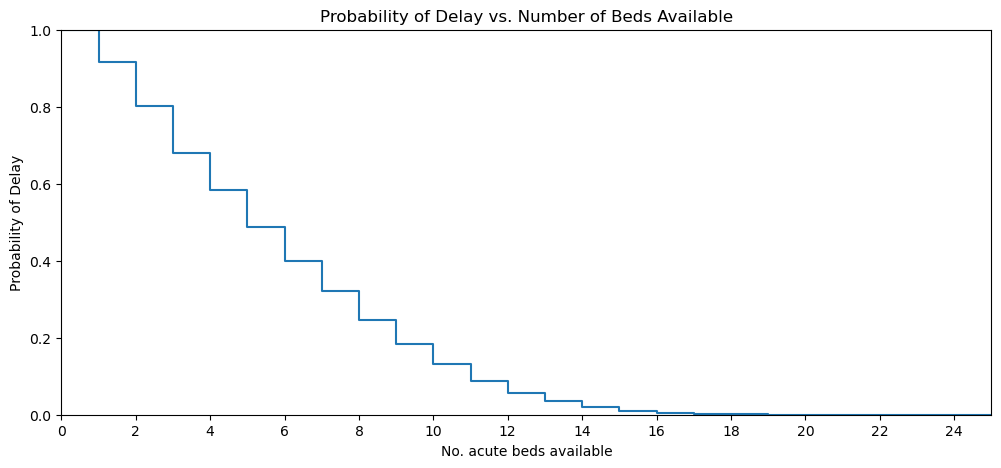

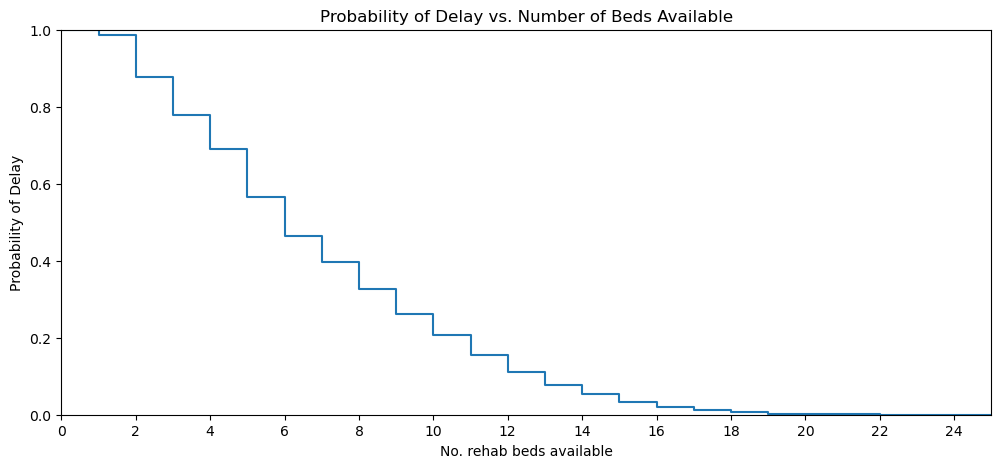

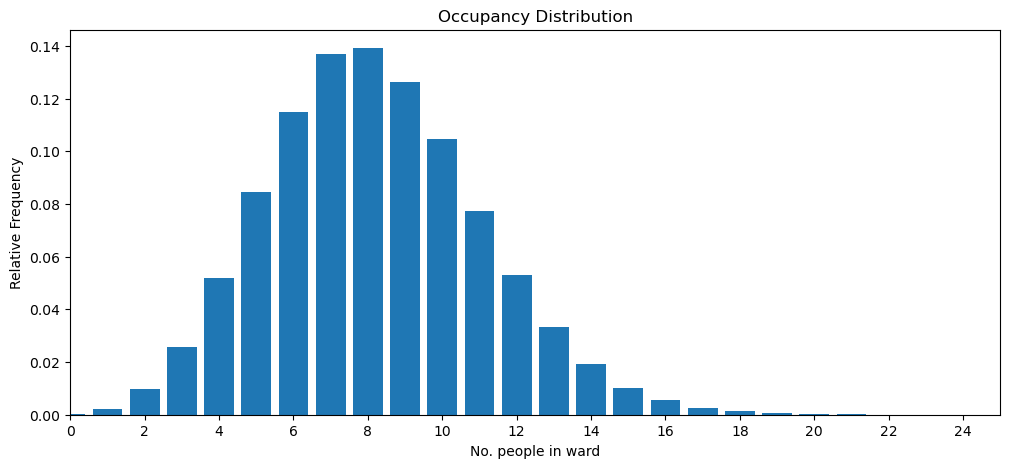

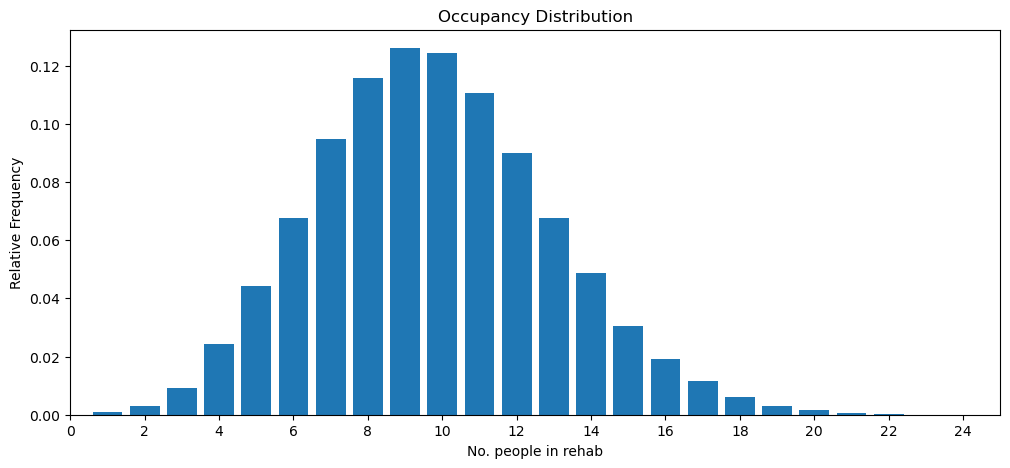

In [8]:
# create experiment
default_experiment = Experiment()

# conduct multiple independent replications and store results 
rep_results = multiple_replications(default_experiment, num_replications=100)

# combine replication results into single table and calculate the mean distribution
mean_pd_asu, mean_pd_rehab, mean_rel_asu, mean_rel_rehab = get_mean_results(rep_results)

# plots
plots = {}
# prob delay plots (each entry is a (fig, ax))
plots['pd_asu'] = prob_delay_plot(mean_pd_asu, np.arange(len(mean_pd_asu)))
plots['pd_rehab'] = prob_delay_plot(mean_pd_rehab, np.arange(len(mean_pd_rehab)), "No. rehab beds available")

# prob occupancy plots
plots['occup_asu'] = occupancy_plot(mean_rel_asu, np.arange(len(mean_pd_asu)))
plots['occup_rehab'] = occupancy_plot(mean_rel_rehab, np.arange(len(mean_pd_rehab)), "No. people in rehab")

## Tabular results

In [9]:
df_acute = summary_table(mean_pd_asu, 9, 14, "acute")
df_rehab = summary_table(mean_pd_rehab, 10, 16, "rehab")

In [10]:
df_acute

,Probability of delay,% patients delayed,1 in every n patients delayed
No. acute beds,,,
9,0.18,18.3%,5
10,0.13,13.2%,7
11,0.09,8.9%,11
12,0.06,5.7%,17
13,0.03,3.5%,28
14,0.02,2.0%,51


In [11]:
df_rehab

,Probability of delay,% patients delayed,1 in every n patients delayed
No. rehab beds,,,
10,0.21,20.6%,4
11,0.15,15.5%,6
12,0.11,11.2%,8
13,0.08,7.8%,12
14,0.05,5.3%,18
15,0.03,3.2%,31
16,0.02,2.0%,50


## Save plots

As an example we will save the ASU probability of delay plot to file, using standard `matplotlib` functionality.

In [12]:
fig = plots['pd_asu'][0]
fig.savefig('prob_delay_asu.png', dpi=300, bbox_inches='tight')